1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(10, 224, 224, 3))']
  warnings.warn(msg)
C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(20, 224, 224, 3))']
  warnings.warn(msg)


C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


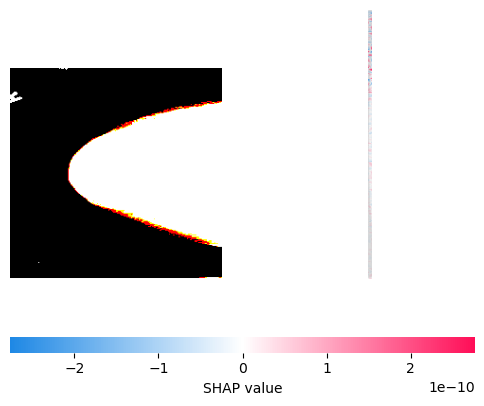


Predicted: Benign (1.00) | Actual: Benign


In [5]:
import os
import random
import numpy as np
import shap
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image

# === Load trained Keras model ===
model = tf.keras.models.load_model("pretrained_model/Resnet50.keras")  # Update with your actual path

# === Settings ===
img_size = (224, 224)
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"

# === Load image paths and labels ===
image_paths, labels = [], []
for label_folder in ["0", "1"]:  # 0 = Benign, 1 = Malignant
    folder = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, fname))
            labels.append(int(label_folder))

# === Select a random image ===
idx = random.randint(0, len(image_paths) - 1)
img_path = image_paths[idx]
true_label = labels[idx]

# === Load and preprocess selected image ===
img = Image.open(img_path).convert('RGB').resize(img_size)
img_array = np.array(img).astype(np.float32)
input_img = tf.keras.applications.resnet50.preprocess_input(img_array.copy())
input_tensor = np.expand_dims(input_img, axis=0)  # Shape: (1, 224, 224, 3)

# === Make prediction ===
pred_prob = model.predict(input_tensor)[0][0]
pred_class = 1 if pred_prob < 0.5 else 0  # Based on your label logic

# === Create background dataset for SHAP (10 benign samples) ===
background_samples = []
count = 0
for i, path in enumerate(image_paths):
    if labels[i] == 0:  # Only benign as baseline
        img_b = Image.open(path).convert('RGB').resize(img_size)
        arr = tf.keras.applications.resnet50.preprocess_input(np.array(img_b).astype(np.float32))
        background_samples.append(arr)
        count += 1
        if count == 10:
            break
background_tensor = np.stack(background_samples, axis=0)

# === SHAP explanation ===
explainer = shap.DeepExplainer(model, background_tensor)
shap_values = explainer.shap_values(input_tensor)

# === Ensure input_tensor is a NumPy array for SHAP plotting ===
input_np = input_tensor.numpy() if isinstance(input_tensor, tf.Tensor) else input_tensor

# === Plot SHAP values (explaining output neuron 0 for sigmoid) ===
shap.image_plot([shap_values[0]], input_np)

# === Print prediction and actual info ===
actual = "Malignant" if true_label == 1 else "Benign"
predicted = "Malignant" if pred_class == 1 else "Benign"
print(f"\nPredicted: {predicted} ({pred_prob:.2f}) | Actual: {actual}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 897ms/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


PartitionExplainer explainer: 3it [00:16, 16.60s/it]               


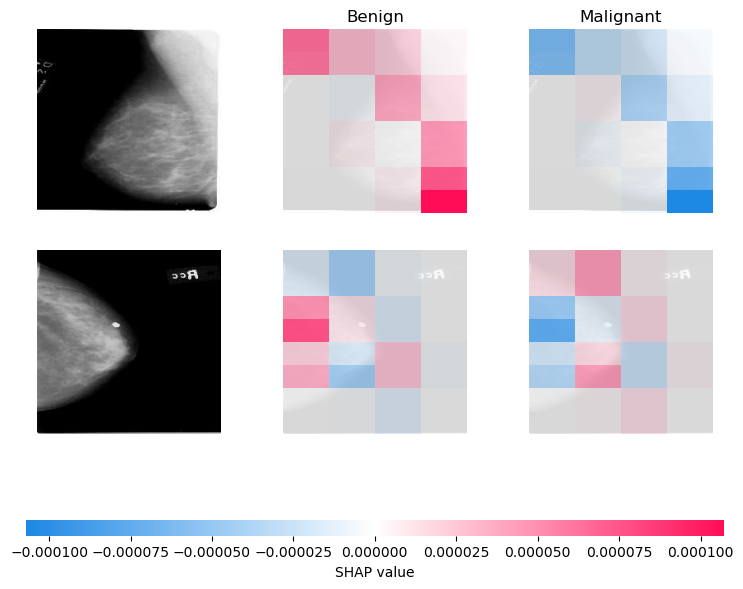


--- Model Predictions ---
Image 1: 
  ➤ Actual:    Benign
  ➤ Predicted: Benign (1.0000)
Image 2: 
  ➤ Actual:    Malignant
  ➤ Predicted: Malignant (0.0537)


In [10]:
import shap
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import os
import random

# ========== CONFIG ==========
model_path = "pretrained_model/Resnet50.keras"
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"
class_names = ["Benign", "Malignant"]
img_size = 224

# ===== LOAD MODEL =====
model = load_model(model_path)

# ===== LOAD RAW IMAGES (recursively from subfolders) =====
def load_images_from_folder(folder, max_images=5):
    image_paths = []
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, fname))

    selected_paths = random.sample(image_paths, min(max_images, len(image_paths)))

    images = []
    for path in selected_paths:
        img = image.load_img(path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        images.append(img_array)

    return np.array(images).astype(np.float32), selected_paths

# Load random images and paths
X, paths = load_images_from_folder(data_dir, max_images=5)

# ===== DEFINE PREDICT FUNCTION =====
def f(x):
    x_preprocessed = preprocess_input(x.copy())
    return model.predict(x_preprocessed)

# ===== DEFINE MASKER =====
masker = shap.maskers.Image("blur(64,64)", X[0].shape)

# ===== CREATE EXPLAINER =====
explainer = shap.Explainer(f, masker, output_names=class_names)

# ===== EXPLAIN IMAGES (select any 2 images for SHAP) =====
X_sample = X[1:3]
paths_sample = paths[1:3]

shap_values = explainer(
    X_sample,
    max_evals=100,
    batch_size=50,
    outputs=shap.Explanation.argsort.flip[:2]
)

# ===== PLOT SHAP RESULTS =====
shap.image_plot(shap_values, X_sample_display)

print("\n--- Model Predictions ---")
for i, p in enumerate(preds):
    prob = p[0]  # Extract scalar
    pred_label = "Malignant" if prob < 0.5 else "Benign"
    
    # Extract actual class from path
    class_folder = os.path.basename(os.path.dirname(paths_sample[i]))
    true_label = "Malignant" if class_folder == "1" else "Benign"
    
    # Print result
    print(f"Image {i+1}: ")
    print(f"  ➤ Actual:    {true_label}")
    print(f"  ➤ Predicted: {pred_label} ({prob:.4f})")
